### Import Libraries

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Gaussian Filter in Frequency Domain

In [28]:
img_path = "lenna.jpeg"
img = plt.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

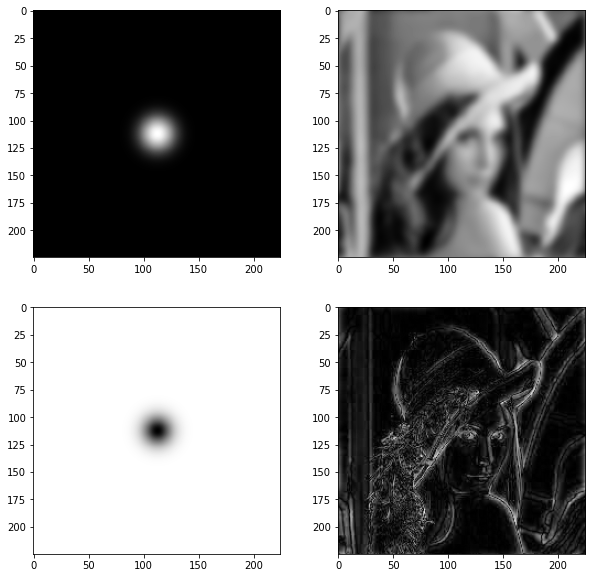

In [40]:
# fft
g_shift = np.fft.fftshift(np.fft.fft2(gray))

# gaussian filter
M, N = gray.shape       # M->Row, N->Col
H = np.zeros((M, N), dtype=np.float32)

D0 = 10   # cut off frequency
for u in range(M):
    for v in range(N):
        D = np.sqrt((u - M/2) ** 2 + (v - N/2) ** 2)
        H[u, v] = np.exp((-D**2) / (2 * D0 * D0))

# low pass
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(np.log1p(H), cmap='gray')
plt.subplot(2,2,2)
plt.imshow(np.abs(np.fft.ifft2(np.fft.ifftshift(g_shift * H))), cmap='gray')
# high pass
hpf = 1 - H
plt.subplot(2,2,3)
plt.imshow(np.log1p(hpf), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(np.abs(np.fft.ifft2(np.fft.ifftshift(g_shift * hpf))), cmap='gray')

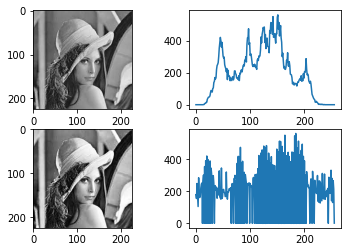

In [44]:
gray_hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

L = 256
row, col = gray.shape
img_size = row * col

cdf = gray_hist.cumsum()
cdf_min = cdf.min()

equalize_img = np.zeros((row, col), np.uint8)
for x in range(row):
    for y in range(col):
        equalize_img[x, y] = ((cdf[gray[x, y]] - cdf_min) / (img_size - cdf_min)) * (L-1)

equalize_img_hist = cv2.calcHist([equalize_img], [0], None, [256], [0, 256])

plt.subplot(2,2,1)
plt.imshow(gray, cmap='gray')
plt.subplot(2,2,2)
plt.plot(gray_hist)
plt.subplot(2,2,3)
plt.imshow(equalize_img, cmap='gray')
plt.subplot(2,2,4)
plt.plot(equalize_img_hist)

### Histogram Shifting

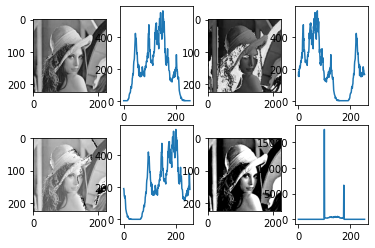

In [45]:
row, col = gray.shape
left_shift, right_shift, narrow_band = gray.copy(), gray.copy(), gray.copy()

# left shift and right shift
left_shift = left_shift - 78
right_shift = right_shift + 50

# for narrow band
for x in range(row):
    for y in range(col):
        if narrow_band[x, y] <= 100:
            narrow_band[x, y] = 100
        elif narrow_band[x, y] >= 175:
            narrow_band[x, y] = 175

gray_hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
left_shift_hist = cv2.calcHist([left_shift], [0], None, [256], [0, 256])
right_shift_hist = cv2.calcHist([right_shift], [0], None, [256], [0, 256])
narrow_band_hist = cv2.calcHist([narrow_band], [0], None, [256], [0, 256])

plt.subplot(2,4,1)
plt.imshow(gray, cmap='gray')
plt.subplot(2,4,2)
plt.plot(gray_hist)
plt.subplot(2,4,3)
plt.imshow(left_shift, cmap='gray')
plt.subplot(2,4,4)
plt.plot(left_shift_hist)
plt.subplot(2,4,5)
plt.imshow(right_shift, cmap='gray')
plt.subplot(2,4,6)
plt.plot(right_shift_hist)
plt.subplot(2,4,7)
plt.imshow(narrow_band, cmap='gray')
plt.subplot(2,4,8)
plt.plot(narrow_band_hist)

### Salt and Pepper Noise

In [48]:
from numpy.random import randint

original = gray.copy()
noise_img = gray.copy()          # to ignore reference error!!! don't worry!!!

row, col = gray.shape
noises = row * col // 50        # total noises you want to add

# add noises
for _ in range(noises):
    x, y = randint(0, row), randint(0, col)
    noise_img[x, y] = randint(0, 2) * 255

# kernel
g_kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
avg_kernel = np.ones((3, 3)) / 9

# filtering
gray_avg_filtered = cv2.filter2D(original, -1, avg_kernel)
g_filtered = cv2.filter2D(noise_img, -1, g_kernel)
avg_filtered = cv2.filter2D(noise_img, -1, avg_kernel)
median_filtered = cv2.medianBlur(noise_img, 3)

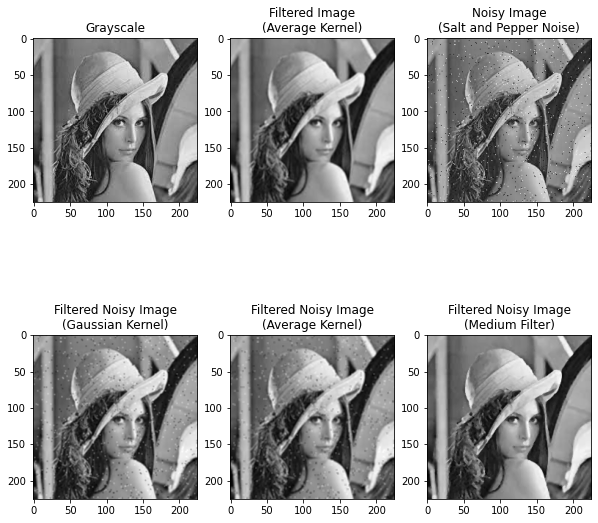

In [52]:
img_set = [original, gray_avg_filtered, noise_img,
           g_filtered, avg_filtered, median_filtered]

img_title = [
    "Grayscale",
    "Filtered Image\n(Average Kernel)",
    "Noisy Image\n(Salt and Pepper Noise)",
    "Filtered Noisy Image\n(Gaussian Kernel)",
    "Filtered Noisy Image\n(Average Kernel)",
    "Filtered Noisy Image\n(Medium Filter)",
]

plt.figure(figsize=(10,10))

for i in range(len(img_set)):
    plt.subplot(2, 3, i + 1)
    plt.title(img_title[i])
    plt.imshow(img_set[i], cmap="gray")

# plt.savefig("Salt-Pepper Noise.png")
plt.show()

### Erosion and Dilation 

In [53]:
def erosion(img, kernel):
    row, col = img.shape
    r, c = kernel.shape

    cutoff = np.sum(kernel) * 255
    new_img = np.zeros((row - r + 1, col - r + 1), dtype=np.uint8)
    for x in range(row - r + 1):
        for y in range(col - r + 1):
            temp = np.sum(np.multiply(img[x:x+r, y:y+c], kernel))
            if temp == cutoff:
                new_img[x, y] = 255

    return new_img

def dilation(img, kernel):
    row, col = img.shape
    r, c = kernel.shape

    cutoff = 255
    new_img = np.zeros((row - r + 1, col - r + 1), dtype=np.uint8)
    for x in range(row - r + 1):
        for y in range(col - r + 1):
            temp = np.sum(np.multiply(img[x:x+r, y:y+c], kernel))
            if temp >= cutoff:
                new_img[x, y] = 255

    return new_img

### Convert Image

In [ ]:
from PIL import Image

# To convert the image From JPG to PNG : {Syntax}
img = Image.open("Image.jpg")
img.save("Image.png")

# To convert the Image From PNG to JPG
img = Image.open("Image.png")
img.save("Image.jpg")